
ReLU defense
==============================

**Author:** https://github.com/aliborji/ReLU_defense.git



In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [231]:
def test_noise( model, device, test_loader, epsilon, do_mask=False ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # only necessary for the edge maps
        data = (data - data.min()) / (data.max() - data.min())        
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
#         import pdb; pdb.set_trace()
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # loss = F.cross_entropy(output, target)        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
#         import pdb; pdb.set_trace()
        # do edge detection on edge detected data
#         perturbed_data = detect_edge(perturbed_data.detach())
#         perturbed_data = torch.from_numpy(perturbed_data)
#         perturbed_data = (perturbed_data - perturbed_data.min()) / (perturbed_data.max() - perturbed_data.min())        

        # masking    x
        if do_mask:
            perturbed_data = apply_filter(perturbed_data)
#             perturbed_data = perturbed_data * data
            


        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [61]:
count = 0
x =0
model.eval()
for data, target in test_loader_new_edge:

    # Send the data and label to the device
#     data, target = data.to(device), target.to(device)
    
#     import pdb; pdb.set_trace()

#     output = model(evaluate_x[x,None,...][None])
#     pred = output.data.max(1)[1]
#     count += pred.eq(evaluate_y[x].data)
#     x +=1

#     output = model(evaluate_x[x,None,...][None])
#     pred = output.data.max(1)[1]
#     count += pred.eq(evaluate_y[x].data)
#     x +=1


    data = (data - data.min()) / (data.max() - data.min())
    output = model(data)
    pred = output.data.max(1)[1]
    count += pred.eq(target.data)

    
#     init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

#     # If the initial prediction is wrong, dont bother attacking, just move on
#     if init_pred.item() == target.item():
#         count += 1

print(count/float(len(test_loader_new_edge)))        


tensor([0.7185])


In [ ]:
plt.imshow(data[0,0]); plt.show()
data[0,0].dtype

In [39]:
len(test_loader_new_edge)
count
# x

tensor([10000])

In [54]:
# del test_loader_new
evaluate_x[x,None,...][None].max()
data[0,0].max()

tensor(0.0039)

In [ ]:
plt.imshow(test_loader.dataset.data[0]); plt.show()
plt.imshow(test_loader_new_edge.dataset.data[0]); plt.show()
plt.imshow(test_loader_edge.dataset.data[0]); plt.show()

In [ ]:
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
# pretrained_model = "/gdrive/My Drive/Tmp/lenet_mnist_model.pth"
# pretrained_model = '/gdrive/My Drive/Tmp/cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
# path = '/gdrive/My Drive/Tmp/slope_models/'
# path = 'model/slope_models/'

pretrained_model = "/models/lenet_mnist_model.pth"
use_cuda=True

In [5]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# training a model first

In [8]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



In [9]:
pretrained_model = "models/lenet_mnist_model.pth"
model = Net().to(device)  # training with slope 1 for now
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


<All keys matched successfully>

In [10]:
from torchsummary import summary
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vgg = models.vgg16().to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [14]:
from skimage import io, color, feature

def detect_edge(data):
    edge_maps = np.zeros_like(data)
    for idx,img in enumerate(data):
#         import pdb; pdb.set_trace()
        edge_maps[idx,0] = feature.canny(np.array(img[0], dtype=np.float64), sigma = 1)

    return edge_maps
    

## convert all the images in the train set

In [15]:
train_loader_edge = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader_edge = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)


xx = detect_edge(train_loader_edge.dataset.data[:,None])
train_loader_edge.dataset.data = xx[:,0]

xx = detect_edge(test_loader_edge.dataset.data[:,None])
test_loader_edge.dataset.data = xx[:,0]


del xx

train_loader_edge.dataset.data = torch.from_numpy(train_loader_edge.dataset.data)
test_loader_edge.dataset.data = torch.from_numpy(test_loader_edge.dataset.data)



In [ ]:
# # for idx,i in enumerate(train_loader_edge.dataset):
# #     train_loader_edge.dataset[idx][0][0] = torch.from_numpy(detect_edge(i[0][None])[0,0])
# xx = detect_edge(test_loader_edge.dataset.data[:,None])
# test_loader_edge.dataset.data = xx[:,0]




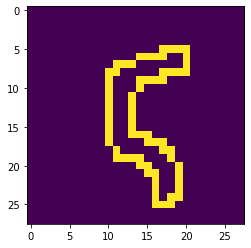

In [16]:
# xx[:,0].shape
plt.imshow(train_loader_edge.dataset.data[100]); plt.show()

In [ ]:
# img = train_loader_edge.dataset[1]
# train_loader_edge.dataset[0][0][0] = torch.from_numpy(detect_edge(img[0][None])[0,0])
# xx = torch.from_numpy(detect_edge(img[0][None])[0,0])
# plt.imshow(train_loader_edge.dataset[1][0][0]); plt.show()
# plt.imshow(xx); plt.show()

In [ ]:
# train_loader_edge.dataset.data.shape
# train_loader_edge.dataset.data[:,None].shape

In [ ]:
# type(detect_edge(i[0][None])[0,0])

In [ ]:
# type(train_loader_edge.dataset[idx][0][0])

In [ ]:
print(len(train_loader_edge.dataset.data))
print(len(train_loader.dataset.data))

In [17]:
EPOCHS = 3
losses = []

optimizer = optim.Adadelta(model.parameters()) #, lr=(1e-3))


model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader_edge):
        
        # add noise
        # import pdb; pdb.set_trace()
#         data = detect_edge(np.array(np.copy(data)))
#         data = torch.Tensor(data.tolist())
        # send to device

        data, target = data.to(device), target.to(device)        

        
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        
        # loss = F.cross_entropy(y_pred, target)
        loss = F.nll_loss(y_pred, target)        
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader_edge.dataset),
                100. * batch_idx / len(train_loader_edge), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = test_loader_edge.dataset.data.type_as(torch.FloatTensor())
    evaluate_y = test_loader_edge.dataset.targets

    evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        


    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader_edge.dataset), 
        len(train_loader_edge.dataset),
        100. * batch_idx / len(train_loader_edge), 
        loss.cpu().data,
        accuracy*100,
        end=''))
    

    

 Train Epoch: 1/3 [60000/60000 (100%)]	Loss: 2.294911	 Test Accuracy: 72.4000%
 Train Epoch: 2/3 [60000/60000 (100%)]	Loss: 2.308409	 Test Accuracy: 72.3200%
 Train Epoch: 3/3 [60000/60000 (100%)]	Loss: 2.303619	 Test Accuracy: 71.8500%


In [ ]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

In [ ]:

from scipy import ndimage
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [ ]:
# import cv2 
# # edge_map = auto_canny(np.array(data[0,0], dtype=np.uint8))
# edges = cv2.Canny(np.array(data[10,0], dtype=np.uint8),300,600)
# plt.imshow(data[0,0])
# plt.show()
# plt.imshow(edges)
# plt.show()

# edges_sobel = sobel_filters(np.array(data[10,0], dtype=np.float64))
# plt.imshow(edges_sobel[1])
# plt.show()




from skimage import io, color, feature

for i in np.arange(1):

    digit_edge = feature.canny(np.array(data[i,0], dtype=np.float64), sigma = 1)

    plt.imshow(digit_edge)
    plt.show()




In [ ]:
# edges_sobel[0].dtype
# data[0,0].dtype


In [ ]:
# (np.array(data[0,0], dtype=np.uint8)).shape

In [ ]:
torch.save(model.state_dict(), 'models/model_mnist_edge.pth')

In [26]:
# test on edge data
model.eval()
evaluate_x = test_loader_edge.dataset.data.type_as(torch.FloatTensor())
evaluate_y = test_loader_edge.dataset.targets.type_as(torch.FloatTensor())

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

model.eval()
output = model(evaluate_x[0,None,...][None])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y[0].data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(100., dtype=torch.float64)


In [27]:
pred

tensor([7])

In [ ]:
test_loader_edge.dataset.data[0][None,None].shape

In [ ]:
plt.imshow(evaluate_x[10]); plt.show()
plt.imshow(test_loader_edge.dataset.data[10]); plt.show()

output = model(test_loader_edge.dataset.data[10][None,None].type_as(torch.FloatTensor()))
print(output.data.max(1)[1])

In [25]:
evaluate_x[0,None,...].shape

torch.Size([1, 28, 28])

# Now perform adversarial attack

## On original data

In [ ]:
# # MNIST Test dataset and dataloader declaration
test_loader_new = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)



epsilons = [0, .05, .1, .15, .2, .25, .3]

model.eval()

# Run test for each epsilon
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader_new, eps)
    accuracies.append(acc)
    examples.append(ex)



In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
# Epsilon: 0	Test Accuracy = 9104 / 10000 = 0.9104
# Epsilon: 0.05	Test Accuracy = 7945 / 10000 = 0.7945
# Epsilon: 0.1	Test Accuracy = 6320 / 10000 = 0.632
# Epsilon: 0.15	Test Accuracy = 4208 / 10000 = 0.4208
# Epsilon: 0.2	Test Accuracy = 2305 / 10000 = 0.2305
# Epsilon: 0.25	Test Accuracy = 913 / 10000 = 0.0913
# Epsilon: 0.3	Test Accuracy = 339 / 10000 = 0.0339

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## On edge maps

In [19]:
# # # MNIST Test dataset and dataloader declaration
# test_loader_new_edge = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             ])), 
#         batch_size=1, shuffle=False)


# xx = detect_edge(test_loader_new_edge.dataset.data[:,None])
# test_loader_new_edge.dataset.data = xx[:,0]


# del xx

# test_loader_new_edge.dataset.data = torch.from_numpy(test_loader_new_edge.dataset.data)

tensor(1, dtype=torch.uint8)

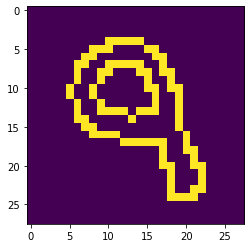

In [59]:
plt.imshow(test_loader_new_edge.dataset.data[4000])
test_loader_new_edge.dataset.targets[4000]
test_loader_new_edge.dataset.data[4000].max()

In [237]:
# # MNIST Test dataset and dataloader declaration
# test_loader_new_edge = torch.utils.data.DataLoader(test_loader_edge.dataset)


epsilons = [0, .05, .1, .15, .2, .25, .3]

model.eval()

# Run test for each epsilon
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test_noise(model, device, test_loader_new_edge, eps, do_mask=True)
    accuracies.append(acc)
    examples.append(ex)



Epsilon: 0	Test Accuracy = 5074 / 10000 = 0.5074
Epsilon: 0.05	Test Accuracy = 3780 / 10000 = 0.378
Epsilon: 0.1	Test Accuracy = 2420 / 10000 = 0.242
Epsilon: 0.15	Test Accuracy = 1277 / 10000 = 0.1277
Epsilon: 0.2	Test Accuracy = 513 / 10000 = 0.0513
Epsilon: 0.25	Test Accuracy = 189 / 10000 = 0.0189
Epsilon: 0.3	Test Accuracy = 76 / 10000 = 0.0076


IndexError: list index out of range

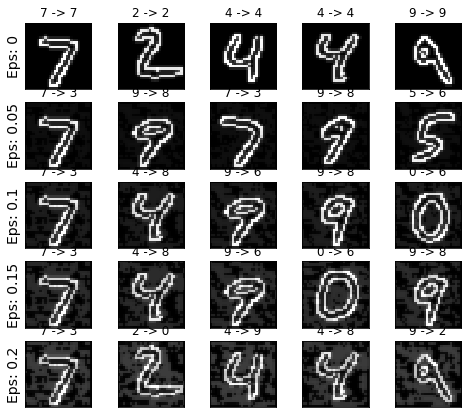

In [232]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

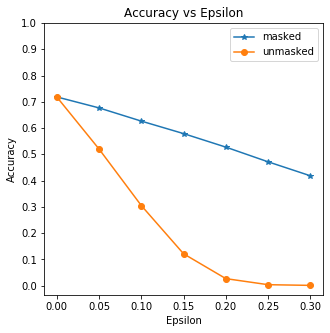

In [100]:
masked = [0.7185, 0.6767, 0.6264, 0.5788, 0.5273 ,0.4713, 0.4181]

unmasked = [0.7185, 0.5201, 0.3048,0.1211,0.0265,0.0034, 0.0008]


plt.figure(figsize=(5,5))
plt.plot(epsilons, masked, "*-")
plt.plot(epsilons, unmasked, "o-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(['masked', 'unmasked'])
plt.show()

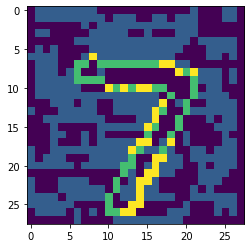

In [121]:
plt.imshow(examples[6][0][2]); plt.show()

In [120]:
i

6